# Insights from CrossFit Games Data

<a href="https://ca.linkedin.com/in/antonrubisov">Anton Rubisov</a>, <a href="http://sportsanalytics.sa.utoronto.ca/">University of Toronto Sports Analytics Group</a>

<img src="http://www.dafont.com/forum/attach/orig/5/0/507820.png" align="right" width="25%"> The CrossFit Games are the world's premier test to find the Fittest on Earth™. They are world-renowned as a grueling test for the toughest athletes on Earth as well as a thrilling experience for spectators. <cite>http://games.crossfit.com/about-the-games</cite>

The Games are structured into three stages: the Open, the Regionals, and the Games. To participate in the Open, an athlete creates a profile on the portal, and submits their scores for the weekly workouts done either in their home gym or videotaped and posted online. On conclusion of the Open, the top athletes proceed to the Regionals where this is repeated in-person in several locations around the world, and the top of the Regionals are invited to California for the annual Games. 


## CrossFit Games as a Data Science Project
What makes this a fascinating data science project is that athletes are encouraged to self-report their athletic benchmark statistics on their profile, all of which are available publicly. The result is having access to statistics on about 70,000 athletes, ranging from descriptive parameters such as age, weight, and gender, to their benchmarks on squats, bench press, and 5km run times, to performance in the various stages of the Games. 

While the Games performance data is reliable, the self-reported attributes are a prime example of dirty data. See, for example, <a href="http://games.crossfit.com/athlete/109651">the author's own profile page</a>. These attributes are sparse due to not all fields being filled in by every athlete, unverifiable even if the data is correct, and subject to mistakes even when available. A key consideration, then, is cleansing the available data.

## Questions to Explore
1. Accepting the unverifiability of the athlete data, how can we best cleanse the data to eliminate incorrect information while retaining outliers?
2. What relationships exist between the various benchmarks? E.g. how does an athlete's squat compare with her clean & jerk?
3. How well does the distribution of benchmarks support previously postulated standards for weightlifting, such as Mark Rippetoe's Starting Strength table of standards?
4. Can an athlete's attributes be used to predict their performance in the CrossFit Games?

# The Data Set
The original dataset was obtained in January 2015 by iteratively scraping the <a>http://games.crossfit.com/athlete/</a> pages as well as the <a>http://games.crossfit.com/leaderboard/</a> pages using the Python BeautifulSoup package. This provided a snapshot of athlete attributes as of January 2015, as well as performances in the 2012, 2013, and 2014 competitions. The dataset was stored in MongoDB format and later migrated to a pickled pandas DataFrame named <code>crossfit_data.pkl</code>

In [1]:
import pandas as pd
import numpy as np
df = pd.read_pickle('data/crossfit_data.pkl')
print(df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68111 entries, 0 to 68110
Data columns (total 178 columns):
2012-games-workout1-rank         float64
2012-games-workout1-score        object
2012-games-workout10-rank        float64
2012-games-workout10-score       object
2012-games-workout11-rank        float64
2012-games-workout11-score       object
2012-games-workout12-rank        float64
2012-games-workout12-score       object
2012-games-workout13-rank        float64
2012-games-workout13-score       object
2012-games-workout14-rank        float64
2012-games-workout14-score       object
2012-games-workout15-rank        float64
2012-games-workout15-score       object
2012-games-workout2-rank         float64
2012-games-workout2-score        object
2012-games-workout3-rank         float64
2012-games-workout3-score        object
2012-games-workout4-rank         float64
2012-games-workout4-score        object
2012-games-workout5-rank         float64
2012-games-workout5-score        object

Subsequently, in December 2015, the athlete profiles were scraped again to produce another snapshot of athlete attributes, thus offering the potential for year-over-year comparison, along with performance in the 2015 competition. This dataset is stored in <code>crossfit_data_2015.pkl</code> and is reserved for out-of-sample testing.

df_2015 = pd.read_pickle('data/crossfit_data_2015.pkl')
print(df_2015.info(verbose=True))

### Accepting the unverifiability of the athlete data, how can we best cleanse the data to eliminate incorrect information while retaining outliers?

In the scraping process, the raw data was already adjusted to reflect all times (e.g. Run 5K) in seconds, and all weights (e.g. Back Squat) in pounds. Nevertheless, the data collected is still dirty with inaccuracies. For example, the current world record back squat hovers around the 1,000lb level, potentially as high as 1,260lbs. A quick check of the data shows:

In [2]:
print("Number of athletes squatting <= 10 pounds:", df.loc[(df['Back Squat'] > 0) & (df['Back Squat'] < 11)]['athlete_id'].count())
print("Number of athletes that exceed the world record:", df.loc[df['Back Squat'] > 1200]['athlete_id'].count())

Number of athletes squatting <= 10 pounds: 28
Number of athletes that exceed the world record: 11


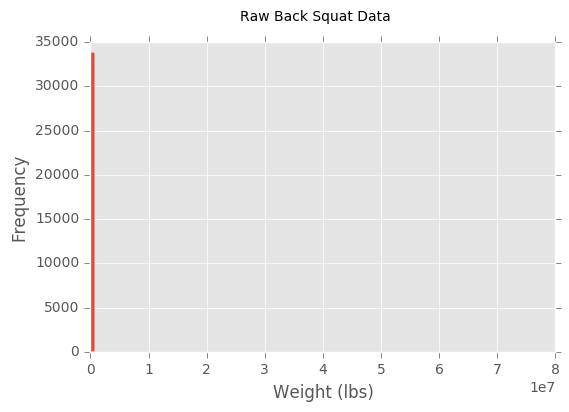

In [3]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
plt.figure()
plt.suptitle('Raw Back Squat Data')
plt.xlabel('Weight (lbs)')
plt.ylabel('Frequency')
plt.hist(df['Back Squat'].dropna(), bins=100);

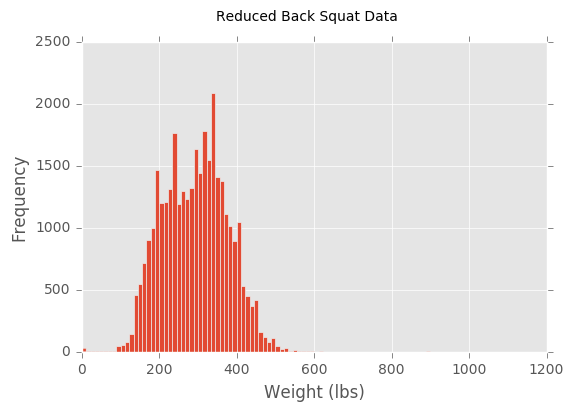

In [4]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
plt.figure()
plt.suptitle('Reduced Back Squat Data')
plt.xlabel('Weight (lbs)')
plt.ylabel('Frequency')
plt.hist(df.loc[(df['Back Squat'] > 0) & (df['Back Squat'] < 1200)]['Back Squat'].dropna(), bins=100);

This appears almost to be a bi-modal normal distribution. In fact, this can be largely be explained by the lack of separation of data by gender. When so done, we see rather well-defined normal distributions for the data:

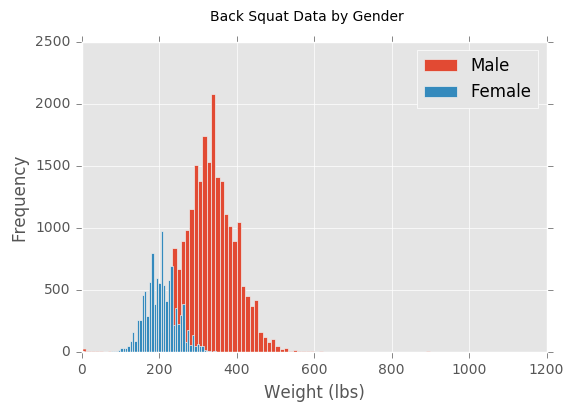

In [5]:
plt.figure()
plt.suptitle('Back Squat Data by Gender')
plt.xlabel('Weight (lbs)')
plt.ylabel('Frequency')
plt.hist(df.loc[(df['Gender'] == 1) & (df['Back Squat'] > 0) & (df['Back Squat'] < 1200)]['Back Squat'].dropna(), bins=100, label='Male');
plt.hist(df.loc[(df['Gender'] == 2) & (df['Back Squat'] > 0) & (df['Back Squat'] < 1200)]['Back Squat'].dropna(), bins=100, label='Female');
plt.legend();

As there is substantially more data for male athletes than for female, and rather than duplicating all calculations for both, we'll focus on the male athlete data. Later we will return to using both.

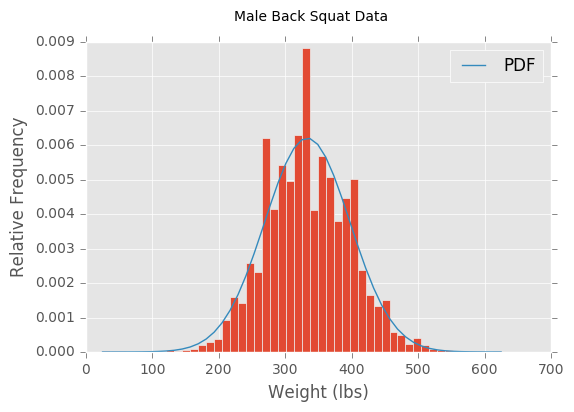

In [6]:
import matplotlib.mlab as mlab
plt.figure()
plt.suptitle('Male Back Squat Data')
plt.xlabel('Weight (lbs)')
plt.ylabel('Relative Frequency')
__, x, __ = plt.hist(df.loc[(df['Gender'] == 1) & (df['Back Squat'] > df['Back Squat'].dropna().quantile(.001)) & (df['Back Squat'] < df['Back Squat'].dropna().quantile(.999))]['Back Squat'].dropna(), normed=1, bins=50)
mu = df.loc[(df['Gender'] == 1) & (df['Back Squat'] > df['Back Squat'].dropna().quantile(.001)) & (df['Back Squat'] < df['Back Squat'].dropna().quantile(.999))]['Back Squat'].dropna().mean()
sigma = df.loc[(df['Gender'] == 1) & (df['Back Squat'] > df['Back Squat'].dropna().quantile(.001)) & (df['Back Squat'] < df['Back Squat'].dropna().quantile(.999))]['Back Squat'].dropna().std()
plt.plot(x,mlab.normpdf(x, mu, sigma),label='PDF');
plt.legend();

Very similar techniques can be applied to cleansing the remaining attributes as well. In so doing, we transform our data from:

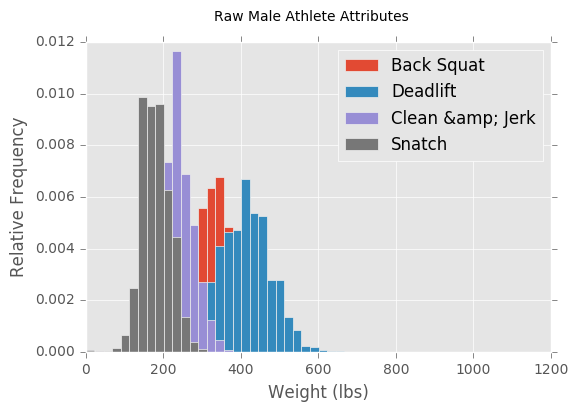

In [7]:
plt.figure()
plt.suptitle('Raw Male Athlete Attributes')
plt.xlabel('Weight (lbs)')
plt.ylabel('Relative Frequency')
for attribute in ['Back Squat','Deadlift','Clean &amp; Jerk','Snatch']:
    plt.hist(df.loc[(df['Gender'] == 1) & (df[attribute] > 0) & (df[attribute] < 1200)][attribute].dropna(), normed=1, bins=50, label=attribute);
plt.legend();

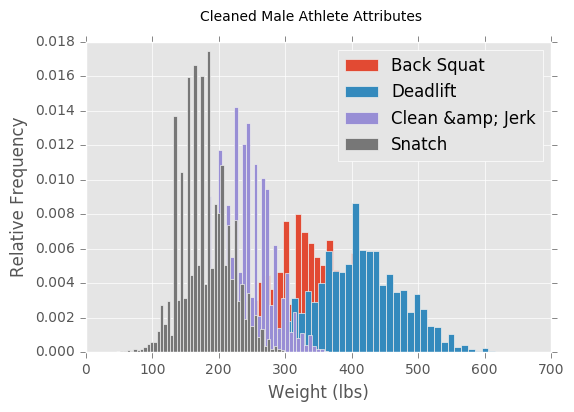

In [22]:
plt.figure()
plt.suptitle('Cleaned Male Athlete Attributes')
plt.xlabel('Weight (lbs)')
plt.ylabel('Relative Frequency')
for attribute in ['Back Squat','Deadlift','Clean &amp; Jerk','Snatch']:
    plt.hist(df.loc[(df['Gender'] == 1) & (df[attribute] > df[attribute].dropna().quantile(.001)) & (df[attribute] < df[attribute].dropna().quantile(.999))][attribute].dropna(), normed=1, bins=50, label=attribute);
plt.legend();

In considering attributes that are time-based, we can use a the same rules to remove unwanted outliers:

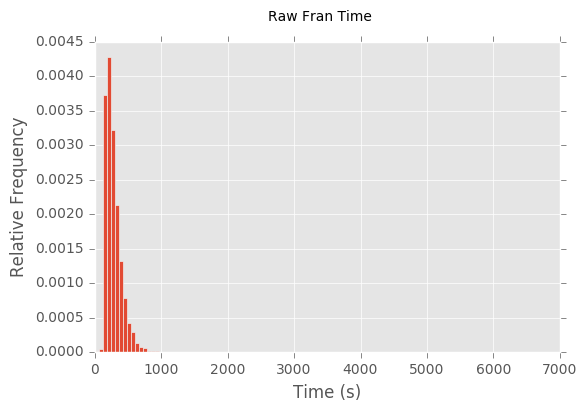

In [9]:
plt.figure()
plt.suptitle('Raw Fran Time')
plt.xlabel('Time (s)')
plt.ylabel('Relative Frequency')
attribute = 'Fran'
plt.hist(df.loc[(df['Gender'] == 1) & (df[attribute] > 0) & (df[attribute] < 10000)][attribute].dropna(), normed=1, bins=100);

Fran is an as-fast-as-possible style workout, with top athletes finishing in the 2min range. A 20min (1200s) timecap is sufficient to include all the data points we care about, and this case, we see that restricting to the 99.9 percentile is actually insufficient, as too many data points are included. The plot on the right restricts to the 99 percentile, and is more appropriate for our use.

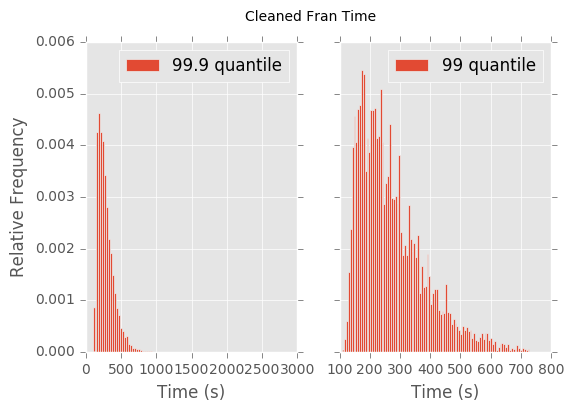

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = f.add_subplot(111, frameon=False, yticks=[], xticks=[]);
plt.suptitle('Cleaned Fran Time');
attribute = 'Fran'
ax1.hist(df.loc[(df['Gender'] == 1) & (df[attribute] > df[attribute].dropna().quantile(.001)) & (df[attribute] < df[attribute].dropna().quantile(.999))][attribute].dropna(), normed=1, bins=100, label='99.9 quantile');
ax2.hist(df.loc[(df['Gender'] == 1) & (df[attribute] > df[attribute].dropna().quantile(.001)) & (df[attribute] < df[attribute].dropna().quantile(.99))][attribute].dropna(), normed=1, bins=100, label='99 quantile');
#ax2.get_yaxis().set_ticklabels([])
ax1.set_xlabel('Time (s)'); ax2.set_xlabel('Time (s)');
ax1.legend(); ax2.legend();
ax1.set_ylabel('Relative Frequency');

This same style of analysis was followed for all the athlete attributes in order to identify the appropriate cutoff quantiles. The table below lists these cutoffs for each attribute. (Note: Age is kept raw due to having no discernible outliers.)

In [11]:
attributes = ['Back Squat',
            'Clean &amp; Jerk',
            'Deadlift',
            'Fight Gone Bad',
            'Filthy 50',
            'Fran',
            'Grace',
            'Height',
            'Helen',
            'Max Pull-ups',
            'Run 5k',
            'Snatch',
            'Sprint 400m',
            'Weight']
cutoffs = pd.DataFrame(data=[[0.001,0.999],
                            [0.001,0.999],
                            [0.001,0.999],
                            [0.001,0.999],
                            [0.005,0.995],
                            [0.001,0.99],
                            [0.001,0.99],
                            [0.01,0.995],
                            [0.001,0.99],
                            [0.001,0.99],
                            [0.01,0.99],
                            [0.001,0.999],
                            [0.001,0.95],
                            [0.01,0.99]],
                      index=attributes,
                      columns=['Lower Quantile','Upper Quantile'])
print(cutoffs)

                  Lower Quantile  Upper Quantile
Back Squat                 0.001           0.999
Clean &amp; Jerk           0.001           0.999
Deadlift                   0.001           0.999
Fight Gone Bad             0.001           0.999
Filthy 50                  0.005           0.995
Fran                       0.001           0.990
Grace                      0.001           0.990
Height                     0.010           0.995
Helen                      0.001           0.990
Max Pull-ups               0.001           0.990
Run 5k                     0.010           0.990
Snatch                     0.001           0.999
Sprint 400m                0.001           0.950
Weight                     0.010           0.990


Using this table of values, we conduct data cleanup across the athlete attributes by converting values that fall outside the allowable quantiles to NaN:

In [12]:
for gender in [1,2]:
    for row in cutoffs.iterrows():
        df.loc[(df['Gender'] == gender) &
               ( ( df[row[0]] < df[row[0]].dropna().quantile(row[1][0]) ) |
                 ( df[row[0]] > df[row[0]].dropna().quantile(row[1][1]) ) ), row[0]] = np.nan

# Data Exploration

### What correlations exist between the various attributes?

In [56]:
df.loc[:,attributes + ['Age']].corr().applymap(lambda x: '%.2f' % x)

,Back Squat,Clean &amp; Jerk,Deadlift,Fight Gone Bad,Filthy 50,Fran,Grace,Height,Helen,Max Pull-ups,Run 5k,Snatch,Sprint 400m,Weight,Age
Back Squat,1.00,0.91,0.91,0.50,-0.35,-0.54,-0.51,0.50,-0.43,0.52,-0.33,0.88,-0.40,0.69,-0.11
Clean &amp; Jerk,0.91,1.00,0.88,0.56,-0.42,-0.60,-0.57,0.55,-0.50,0.59,-0.39,0.95,-0.46,0.67,-0.19
Deadlift,0.91,0.88,1.00,0.49,-0.33,-0.50,-0.48,0.57,-0.44,0.52,-0.35,0.85,-0.41,0.72,-0.09
Fight Gone Bad,0.50,0.56,0.49,1.00,-0.66,-0.64,-0.54,0.21,-0.63,0.57,-0.49,0.57,-0.43,0.22,-0.19
Filthy 50,-0.35,-0.42,-0.33,-0.66,1.00,0.66,0.47,-0.05,0.65,-0.58,0.51,-0.43,0.42,-0.01,0.24
Fran,-0.54,-0.60,-0.50,-0.64,0.66,1.00,0.61,-0.09,0.69,-0.69,0.47,-0.61,0.46,-0.13,0.25
Grace,-0.51,-0.57,-0.48,-0.54,0.47,0.61,1.00,-0.16,0.46,-0.41,0.27,-0.57,0.31,-0.28,0.22
Height,0.50,0.55,0.57,0.21,-0.05,-0.09,-0.16,1.00,-0.16,0.16,-0.22,0.52,-0.24,0.78,0.04
Helen,-0.43,-0.50,-0.44,-0.63,0.65,0.69,0.46,-0.16,1.00,-0.64,0.59,-0.51,0.52,-0.11,0.20
Max Pull-ups,0.52,0.59,0.52,0.57,-0.58,-0.69,-0.41,0.16,-0.64,1.00,-0.50,0.60,-0.48,0.13,-0.19


For ease of analysis, we'll look only at cases were linear correlation is in excess of +/- 0.5:

In [57]:
df.loc[:,attributes + ['Age']].corr().applymap(lambda x: '--' if (x > -0.5) and (x < 0.5) else '%.2f' % x)

,Back Squat,Clean &amp; Jerk,Deadlift,Fight Gone Bad,Filthy 50,Fran,Grace,Height,Helen,Max Pull-ups,Run 5k,Snatch,Sprint 400m,Weight,Age
Back Squat,1.00,0.91,0.91,0.50,--,-0.54,-0.51,0.50,--,0.52,--,0.88,--,0.69,--
Clean &amp; Jerk,0.91,1.00,0.88,0.56,--,-0.60,-0.57,0.55,--,0.59,--,0.95,--,0.67,--
Deadlift,0.91,0.88,1.00,--,--,-0.50,--,0.57,--,0.52,--,0.85,--,0.72,--
Fight Gone Bad,0.50,0.56,--,1.00,-0.66,-0.64,-0.54,--,-0.63,0.57,--,0.57,--,--,--
Filthy 50,--,--,--,-0.66,1.00,0.66,--,--,0.65,-0.58,0.51,--,--,--,--
Fran,-0.54,-0.60,-0.50,-0.64,0.66,1.00,0.61,--,0.69,-0.69,--,-0.61,--,--,--
Grace,-0.51,-0.57,--,-0.54,--,0.61,1.00,--,--,--,--,-0.57,--,--,--
Height,0.50,0.55,0.57,--,--,--,--,1.00,--,--,--,0.52,--,0.78,--
Helen,--,--,--,-0.63,0.65,0.69,--,--,1.00,-0.64,0.59,-0.51,0.52,--,--
Max Pull-ups,0.52,0.59,0.52,0.57,-0.58,-0.69,--,--,-0.64,1.00,-0.50,0.60,--,--,--


**Age**. Interestingly age is not strongly correlated with any other attributes - CrossFit might not be a young person's sport!

**Weightlifting**. Every weightlifting-related attribute - Back Squat, Clean & Jerk, Snatch, Deadlift - are all very strongly positively correlated with each other, as expected. Unsurprisingly, athlete weight has a strong positive correlation with each of these, as heavier lifters tend to lift heavier weights. Athlete height shows a weak positive correlation with each of these as well - a potential explanation here is that taller athletes are able to bear more bodyweight, hence muscle, and thus ultimately lift heavier weights.

**Fran**. Fran is an AFAP (as-fast-as-possible) WOD, and considered to be one of the ultimate CrossFit benchmark workouts. Interestingly, it has a reasonably strong correlation with almost every other attribute. Note that a low score on Fran is better than a high score, and hence a -0.50 correlation with Deadlift implies that as an athlete can deadlift heavier weights, they can complete Fran faster. The strongest correlation is with Max Pull-ups at -0.69, which is noteworthy as pull-ups are one of the two movements in Fran.

In [58]:
#pd.tools.plotting.scatter_matrix(df.loc[:,['Age']], alpha=0.2, figsize=(6, 6), diagonal='kde')

### How well does the distribution of benchmarks support previously postulated standards for weightlifting, such as Mark Rippetoe's Starting Strength table of standards?

Mark Rippetoe is the author of Starting Strength, a bible in the weightlifting community. Included in the book is <a href="">a table of standards for the press, bench press, squat, deadlift, and power clean</a>. Per lift, the table gives weight values for bodyweight and skill level. The footnote reads, "These are performance standards, not norms." The table for the Squat is below:

In [59]:
SS_WEIGHTS_M = [114,123,132,148,165,181,198,220,242,275,319,320]
SS_SQUAT_M = [[78,144,174,240,320],
    [84,155,190,259,346],
    [91,168,205,278,369],
    [101,188,230,313,410],
    [110,204,250,342,445],
    [119,220,269,367,479],
    [125,232,285,387,504],
    [132,244,301,409,532],
    [137,255,311,423,551],
    [141,261,319,435,567],
    [144,267,326,445,580],
    [157,272,332,454,593]]
df_squat_m = pd.DataFrame(SS_SQUAT_M, index=SS_WEIGHTS_M, columns=['Cat. I','Cat. II','Cat. III','Cat. IV','Cat. V'])
print(df_squat_m)

     Cat. I  Cat. II  Cat. III  Cat. IV  Cat. V
114      78      144       174      240     320
123      84      155       190      259     346
132      91      168       205      278     369
148     101      188       230      313     410
165     110      204       250      342     445
181     119      220       269      367     479
198     125      232       285      387     504
220     132      244       301      409     532
242     137      255       311      423     551
275     141      261       319      435     567
319     144      267       326      445     580
320     157      272       332      454     593


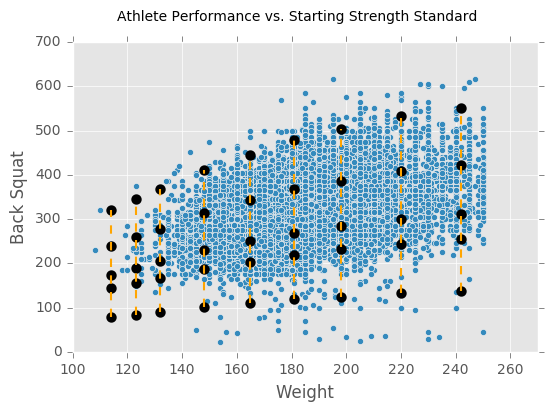

In [60]:
df.loc[df['Gender']==1][['Weight','Back Squat']].plot(kind='scatter', x='Weight', y='Back Squat');
for row in df_squat_m.iterrows():
    plt.plot   (  np.repeat(row[0], len(row[1])),  row[1], linestyle='--', linewidth=1.5, color='orange');
    plt.scatter(x=np.repeat(row[0], len(row[1])),y=row[1], marker='o', linewidths=3, color='black');
plt.xlim([100,270]);
plt.ylim([0,700]);
plt.suptitle('Athlete Performance vs. Starting Strength Standard');

The Categories referred to in the Starting Strength tables can alternatively be referred to in qualitative terms that refer to the athlete's proficiency; for example, <a href="http://www.exrx.net/Testing/WeightLifting/SquatStandards.html">ExRx.net</a> refers to these categories as Untrained, Novice, Intermediate, Advanced, and Elite. It's very interesting to note that the majority of these athletes fall into the two buckets between Intermediate-Advanced and Advanced-Elite, and that there are very few datapoints around Untrained-Novice bucket. Rather than suggesting that the Standards may be inconsistent with reality, an alternate explanation is that anyone competing in the CrossFit Open is already at least at the Novice level, and that generally the competition appeals to the more advanced athlete.

# Machine Learning with the CrossFit Games Data

We'll now use some machine learning tools to explore the data further. There are two fundamental questions we want to look at:
1. Can an athlete's attributes be used to predict their performance in the CrossFit Games?
2. Can we reverse-engineer the ideal CrossFit athlete?

Before beginning, we have the issue of data sparsity. The scikit-learn library does not support NaN values, and thus our missing values need to be filled with some method in order to use any learning algorithms. It's worth noting that missing values account for more than half the data set:

In [62]:
atts = df.loc[:,attributes + ['Age','Gender']].copy()
print("Number of data points:", sum(atts.count()))
print("Number of missing points:", np.isnan(atts).sum().sum())
print("Number of athletes with complete data:", len(atts.dropna()))

Number of data points: 479725
Number of missing points: 610051
Number of athletes with complete data: 1489


The simplest approach is to simply drop any row that is missing a value, which reduces our number of athlete instances to just 2% of the original. We can check what effect this has on our distributions:

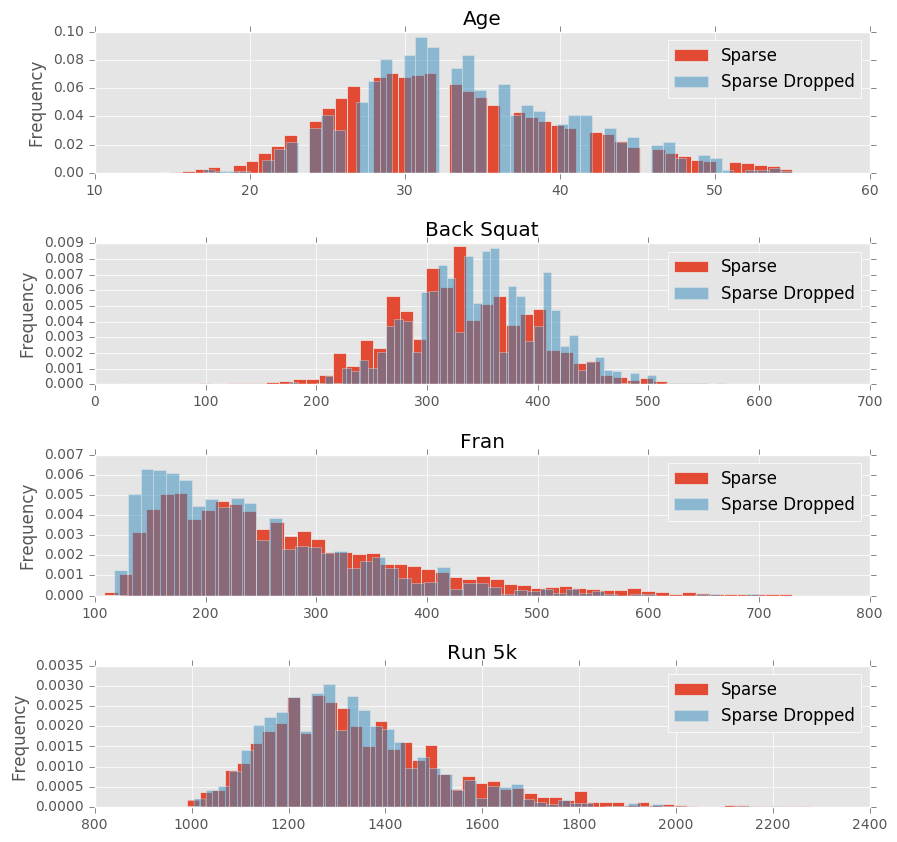

In [64]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10));
plt.subplots_adjust(wspace=0.5, hspace=0.5);
keys = ['Age','Back Squat','Fran','Run 5k']
for i,var in enumerate(keys):
    atts.loc[atts['Gender'] == 1][var].plot(kind='hist', ax=axes[i],  alpha=1, legend=True, sharex=False, sharey=False, normed=1, bins=50, label='Sparse', title=var);
    atts.dropna().loc[atts['Gender'] == 1][var].plot(kind='hist', ax=axes[i], alpha=0.5, legend=True, sharex=False, sharey=False, normed=1, bins=50, label='Sparse Dropped');

While not a perfect match, the above histograms show that the dataset that drops rows containing missing values is a reasonable approximation of the entire dataset, and so calibration on the reduced but complete dataset can still be meaningful.

<a>http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values</a>

Alternatively, we can compare this approach with backfilling the missing data. The python Imputer infers the missing data from the known data, using either mean, median, or most frequent value of those available. We'll use a manual process for this that allows us to infer the mean statistics having grouped by Age and Gender:

In [65]:
imp_atts = df.loc[:,attributes + ['Age', 'Gender']].copy()
for key in attributes + ['Age', 'Gender']:
    imp_atts[key].fillna(imp_atts.groupby(['Age','Gender'])[key].transform("mean"), inplace=True)
    imp_atts[key].fillna(imp_atts[key].mean(), inplace=True)

print("Number of missing points:", np.isnan(imp_atts).sum().sum())

Number of missing points: 0


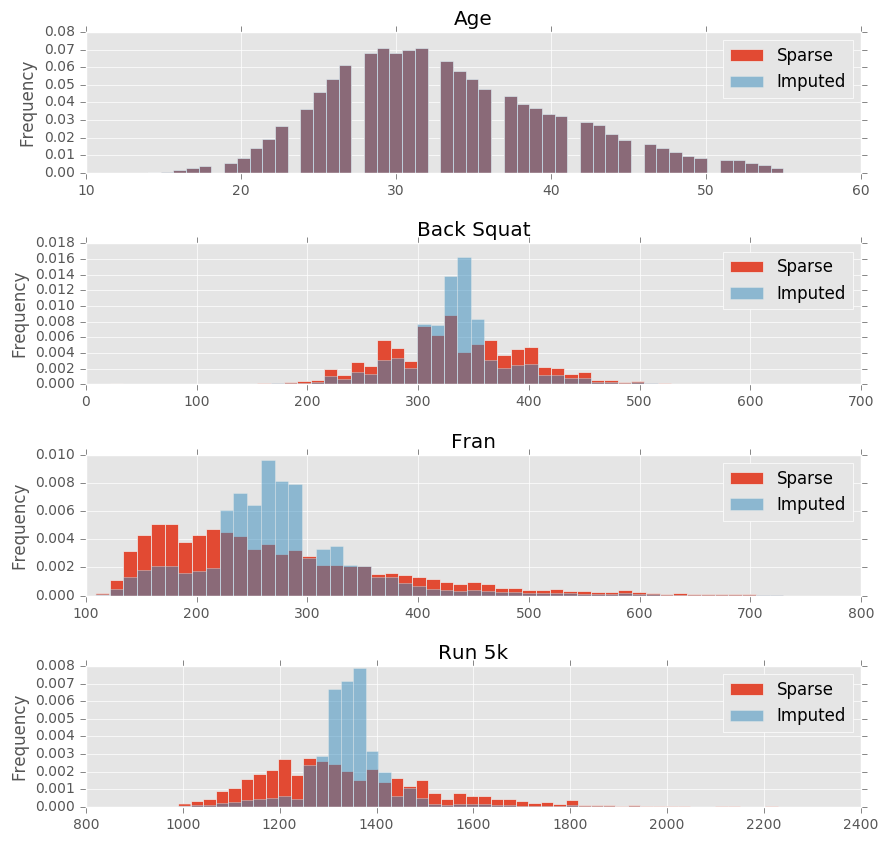

In [66]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10));
plt.subplots_adjust(wspace=0.5, hspace=0.5);
keys = ['Age','Back Squat','Fran','Run 5k']
for i,var in enumerate(keys):
    atts.loc[atts['Gender'] == 1][var].plot(kind='hist', ax=axes[i],  alpha=1, legend=True, sharex=False, sharey=False, normed=1, bins=50, label='Sparse', title=var);
    imp_atts.loc[imp_atts['Gender'] == 1][var].plot(kind='hist', ax=axes[i], alpha=0.5, legend=True, sharex=False, sharey=False, normed=1, bins=50, label='Imputed');

<span style="background-color: #FFFF00">TODO: Imputing values to mean: results in distribution distortion - this approach won't work. Follow-up.</span>

<span style="background-color: #FFFF00">TODO: data needs to be scaled/standardized, since some algorithms (e.g. neural nets) are sensitive to feature scaling.</span>

### Principal Component Analysis to Reduce the Feature Space

<a>http://scikit-learn.org/stable/modules/feature_selection.html</a>

From the correlation analysis of the athlete attributes, we saw that the data supports reducing the feature space considerably. The four weightlifting attributes can likely be reduced to one, and Fran, Grace, Helen, and Filthy 50 can likely be reduced as well. Starting with 15 attributes, ...

<span style="background-color: #FFFF00">TODO: Finish this.</span>

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(atts.dropna())
pca.components_ 

array([[ -8.15369011e-02,  -6.60759112e-02,  -8.49770916e-02,
         -1.17279011e-01,   8.84500548e-01,   1.91710779e-01,
          1.18243544e-01,  -5.97027330e-04,   1.91517534e-01,
         -2.38019869e-02,   3.06685210e-01,  -5.77894965e-02,
          1.61901127e-02,  -1.70396961e-03,   5.30405963e-03],
       [ -1.18622027e-01,  -7.85977223e-02,  -1.58797383e-01,
         -4.66135547e-02,  -3.91505305e-01,   5.29632711e-02,
          2.56725595e-03,  -7.03798097e-03,   1.52194405e-01,
         -1.51629139e-02,   8.75725110e-01,  -5.87069159e-02,
          2.78347939e-02,  -4.14090166e-02,   8.00988045e-04],
       [  4.54829561e-01,   3.05623450e-01,   4.82510494e-01,
          1.40149918e-01,   1.72576980e-01,  -2.97577980e-01,
         -3.57705844e-01,   9.52356254e-03,  -1.19108589e-01,
          2.88306806e-02,   3.24972287e-01,   2.46624177e-01,
         -1.28958208e-02,   1.38572726e-01,  -8.31418943e-03],
       [ -2.78752917e-01,  -1.45901940e-01,  -3.92540478e-01,
     

### Multi-Layer Perceptron Regression

<a>http://scikit-learn.org/stable/modules/neural_networks_supervised.html</a>

### Random Forest Regression

<a>http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html</a>